# Variational Classifier with Quantum Circuits 
***Submitted by Disha Mondal***

This tutorial, inspired by the Pennylane tutorial(cited below) demonstrates how to implement a variational classifier using quantum circuits.

CITATION :
@misc{MariaSchuld2019,
      title = "Variational classifier",
      author = "Maria Schuld",
      year = "2019",
      month = "10",
      journal = "PennyLane Demos",
      publisher = "Xanadu",
      howpublished = "\url{https://pennylane.ai/qml/demos/tutorial_variational_classifier/}",
      note = "Date Accessed: 2024-07-16"
    }

The above mentioned tutorial is followed and implemented and each step is explained in own words.

Overview:

Learning variational classifiers with quantum circuits leverages quantum parallelism and entanglement to potentially solve certain types of complex problems more efficiently than classical classifiers, offering exponential speed-ups in specific tasks like factoring and simulating quantum systems, which are infeasible for classical methods. This approach can lead to advancements in areas such as cryptography, optimization, and machine learning.

Abstract:

The tutorial uses the examples of parity function that uses basis encoding and iris classifier that uses amplitude encoding to demonstrate variational circuits as supervised machine learning models.
# EXAMPLE 1 : FITTING THE PARITY FUNCTION

We will implement a quantum machine learning model to classify bitstrings using the parity function. We will use the PennyLane library to build and train our quantum classifier.

*Basis encoding* in quantum computing involves mapping classical data directly onto the computational basis states of qubits, where each bit in the data corresponds to a specific qubit's state (0 or 1). This method is efficient for representing discrete data but requires a number of qubits equal to the length of the bitstring, making it less scalable for large datasets.

## Step 1: Imports and Setup
In this step, we import the necessary libraries and set up the quantum device.
We start by importing the necessary libraries:
- PennyLane: A library for quantum machine learning.
- NumPy: A library for numerical operations.
- NesterovMomentumOptimizer: An optimizer for training the model(Nesterov Momentum works like the Momentum optimizer, but shifts the current input by the momentum term when computing the gradient of the objective function).


In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Next, we create a quantum device that will run our circuits. We will use the default qubit simulator provided by PennyLane.

In [2]:
dev = qml.device("default.qubit")

## Step 2: Circuit Layer

We define a layer or block, which is a small circuit that will be repeated to build the full variational circuit. Our layer consists of an arbitrary rotation on each qubit followed by a ring of CNOT gates to entangle the qubits.

Entanglement in quantum circuits, achieved through operations like CNOT gates, is crucial for distributing and correlating quantum information across qubits. It enables quantum algorithms to exploit quantum parallelism and potentially achieve computational advantages over classical counterparts by processing states that are inherently interconnected and interdependent.

In [3]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

## Step 3: State Preparation
We need a way to encode data inputs into the circuit. The state_preparation function uses the BasisState function(prepares a basis state on the given wires using a sequence of Pauli-X gates) to set the quantum state according to the input bitstring.

In [4]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

## Step 4: Variational Quantum Circuit
We define the variational quantum circuit, which consists of the state preparation followed by the repeated layers.
The function expval(op) gives expectation value of the supplied observable.

In [5]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

## Step 5: Variational Classifier
To make our model more flexible, we add a classical bias parameter and define the full model as the sum of the quantum circuit output and the bias.

Adding a classical bias parameter allows the variational classifier to shift and fine-tune the decision boundary of the quantum circuit output, enhancing its flexibility and adaptability to different classification tasks. This step is crucial as it enables the quantum model to better fit complex data distributions by adjusting the decision-making process beyond the intrinsic capabilities of the quantum circuit alone.

In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

## Step 6: Cost Function
In supervised learning, we need a cost function to measure the difference between the model's predictions and the actual labels. We use the square loss function for this purpose. The cost function is usually the sum of a loss function and a regularizer (a term added to the cost function to penalize complex models, promoting simplicity and preventing overfitting by discouraging large parameter values).

In [7]:
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

## Step 7: Accuracy
We also define a function to compute the accuracy of our model, which is the proportion of correctly classified examples.

In [8]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

## Step 8 :Cost Wrapper
We define a cost wrapper function that takes the model parameters and the data as input and returns the cost.
This step is crucial as it standardizes the cost calculation process, allowing for systematic adjustment of model parameters to minimize prediction errors and improve overall performance in supervised learning tasks.

In [9]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## Step 9: Data Loading and Preprocessing

We load and preprocess the training data. The labels are shifted from {0, 1} to {-1, 1}.

In [10]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}
for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


## Step 10: Model Initialization
We initialize the model parameters randomly and set a fixed seed for reproducibility.

(In PennyLane, setting `requires_grad=True` during model initialization is significant because it flags the quantum operations (QNodes) to be differentiable with respect to their input parameters. This enables automatic differentiation techniques, such as gradient-based optimization algorithms, to compute gradients of the quantum circuit outputs with respect to the variational parameters. This capability is essential for training quantum machine learning models using gradient descent methods to minimize a defined cost or loss function.)

In [11]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


## Step 11: Optimizer and Training
We create an optimizer instance and choose a batch size. Then we train the model using the optimizer.

In quantum machine learning, an optimizer is essential for adjusting the parameters of a quantum circuit to minimize a defined cost function, guiding the model towards better performance on a given task. By iteratively updating these parameters, the optimizer helps the quantum model learn patterns from the data, improving its accuracy and generalization capabilities.

The Nesterov Momentum Optimizer is a variant of the traditional momentum optimizer commonly used in deep learning. It helps accelerate gradient descent by taking into account future gradients, improving convergence speed and stability in training neural networks.

In [12]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)
    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")


Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

## Step 12: Evaluation on Unseen Data
Finally, we evaluate the trained model on a test set of examples that were not used during training to see how well the model generalizes.

In [13]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)


x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


# EXAMPLE 2: IRIS CLASSIFICATION

OVERVIEW:

Step 1: Data Preparation and Preprocessing

Purpose: To prepare the classical data for use in a quantum circuit.

Explanation:
1. Load the Iris dataset, which contains flower measurements.
2. Select two features from the dataset (in this case, the first two dimensions).
3. Pad the data with additional dimensions (called "latent dimensions") to match the size of the quantum state vector.
4. Normalize the data to ensure all input vectors have the same length.
5. Convert the normalized data into rotation angles for quantum state preparation.

This step is crucial because quantum circuits operate on quantum states, not classical data directly. The preprocessing transforms classical data into a format suitable for quantum processing.

Step 2: Quantum Circuit Design

Purpose: To create a quantum circuit that can process the prepared data and perform classification.

Explanation:
1. Define a state preparation function that encodes the classical data into quantum states.
2. Create a "layer" function that applies rotations and entanglement operations to the qubits.
3. Implement the full variational classifier by combining state preparation and multiple layers.

This quantum circuit acts as the core of the quantum machine learning model. It's designed to manipulate quantum states in a way that can separate different classes of data.

Step 3: Cost Function Definition

Purpose: To quantify how well the model is performing and guide the optimization process.

Explanation:
Define a cost function that measures the difference between the model's predictions and the true labels. In this case, it uses the square loss function.

The cost function is crucial for training the model. It provides a single number that represents how far off the model's predictions are from the correct answers.

Step 4: Data Splitting

Purpose: To assess the model's ability to generalize to unseen data.

Explanation:
1. Randomly split the dataset into training and validation sets.
2. Use 75% of the data for training and 25% for validation.

This split allows us to train the model on one set of data and test its performance on another, unseen set. It helps detect overfitting, where a model performs well on training data but poorly on new data.

Step 5: Model Initialization

Purpose: To set up the initial state of the model before training.

Explanation:
1. Initialize the weights (parameters) of the quantum circuit randomly.
2. Set up the optimizer (in this case, Nesterov Momentum Optimizer) that will update these weights during training.

Initialization is important because it gives the optimization process a starting point. The choice of optimizer can affect how quickly and effectively the model learns.

Step 6: Training Loop

Purpose: To iteratively improve the model's performance on the training data.

Explanation:
1. For a set number of iterations:
   a. Select a random batch of training data.
   b. Compute the cost for this batch.
   c. Use the optimizer to update the weights based on this cost.
   d. Evaluate the model's accuracy on both training and validation sets.
   e. Print out the results periodically.

This is where the actual learning happens. The model repeatedly sees examples, makes predictions, and adjusts its parameters to improve those predictions.

Step 7: Visualization and Evaluation

Purpose: To understand and interpret the model's performance and decision-making.

Explanation:
1. Create a grid of points covering the feature space.
2. Use the trained model to make predictions for each point on this grid.
3. Plot these predictions as a color-coded contour map.
4. Overlay the actual data points on this map.

This visualization helps us see how the model is classifying different regions of the feature space and how well it separates the classes.

In summary, this workflow takes classical data, prepares it for quantum processing, designs a quantum circuit to act as a classifier, trains this classifier using optimization techniques, and finally evaluates and visualizes its performance. This approach leverages quantum computations for machine learning tasks, potentially offering advantages over classical methods for certain types of problems.

NOTE : AMPLITUDE ENCODING APPROACH IS TAKEN.

Amplitude encoding is a method of representing classical data in quantum states by encoding the data values directly into the amplitudes of a quantum state vector. This allows for a more compact representation of data compared to qubit encoding, as it can represent 2^n classical values using only n qubits, but it requires more complex state preparation procedures.

# Step 1: State Preparation
Purpose: Convert classical data into a quantum state.

Details:

The state_preparation function takes the angles computed in the previous step and uses them to prepare the quantum state. This involves a series of rotations and CNOT gates.

In [14]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

#Testing 
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


# Step 2: Model Definition
Purpose: Define the variational quantum classifier.

Details:

The model consists of several layers of quantum gates, parameterized by weights that will be optimized during training.

The layer function defines a single layer of the quantum circuit, and the variational_classifier function stacks multiple layers to form the full model.

In [15]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

## Step 3: Data Preprocessing
Purpose: The goal is to transform the raw Iris dataset into a form suitable for quantum computation.

Details:

-Load the Dataset: The Iris dataset is loaded. For simplicity, we will use a subset of the dataset that contains only two classes.

-Padding: Each data point is padded with two additional dimensions (latent dimensions) to match the size of the quantum state vector.

-Normalization: The padded data points are normalized so that their norm is 1. This is necessary because quantum states must be normalized.

-Feature Extraction: The normalized data points are converted into a set of angles using the get_angles function. These angles will be used for state preparation in the quantum circuit.

In [16]:
import matplotlib.pyplot as plt

data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


Visualization:

We plot the original, padded, and normalized data to understand how preprocessing changes the data distribution.

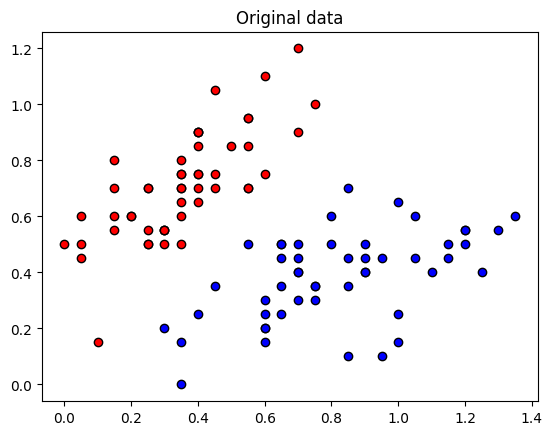

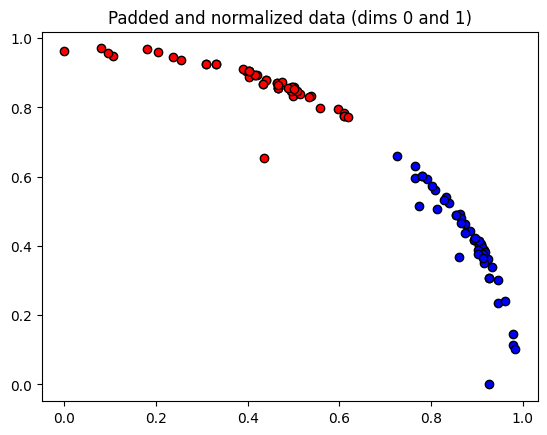

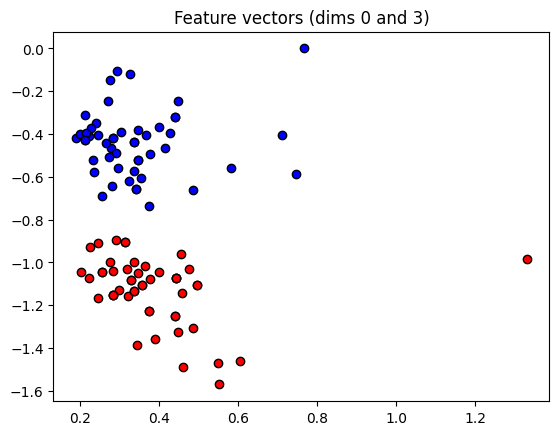

In [17]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalized data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()


# Step 4: Training
Purpose: Optimize the model parameters to minimize the cost function.

Details:

-The dataset is split into training and validation sets to monitor generalization performance.

-The cost function used is the square loss, and we employ a Nesterov momentum optimizer to update the model parameters.

-The model is trained for a fixed number of iterations, with predictions and accuracy computed on both training and validation sets at each iteration.

In [18]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## Optimisation:

In [19]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [20]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

## Step 5: Evaluation
Purpose: Assess the performance of the trained model.

Details:

After training, we visualize the decision boundary learned by the model and plot the classification results on the training and validation sets.

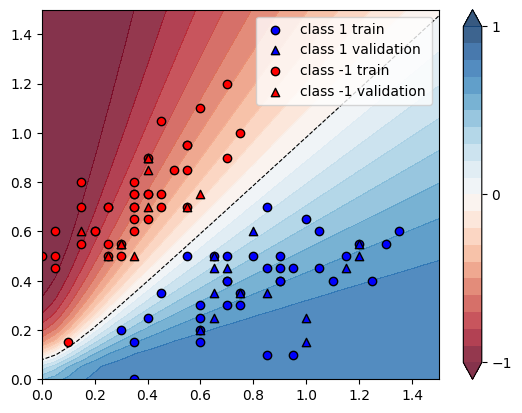

In [21]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()